In [1]:
%matplotlib
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

Using matplotlib backend: Qt5Agg


In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
print(sys.path)

['', 'C:\\Users\\seanm\\Anaconda3\\python35.zip', 'C:\\Users\\seanm\\Anaconda3\\DLLs', 'C:\\Users\\seanm\\Anaconda3\\lib', 'C:\\Users\\seanm\\Anaconda3', 'C:\\Users\\seanm\\Anaconda3\\lib\\site-packages', 'C:\\Users\\seanm\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\seanm\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\seanm\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\seanm\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\seanm\\.ipython', 'C:\\Users\\seanm\\OneDrive\\Documents\\Research\\TauHybridSolver\\GillesPy2']


In [3]:
import math
import gillespy2
from gillespy2.basic_tau_hybrid_solver import BasicTauHybridSolver
from gillespy2.basic_ssa_solver import BasicSSASolver

Unable to use Cython optimized SSA:
Error:No module named 'cython_ssa_solver'


In [34]:

class SimpleHybridModel(gillespy2.Model):
     def __init__(self, parameter_values=None, init_v=1):
            #initialize Model
            gillespy2.Model.__init__(self, name="Simple_Hybrid_Model")

            
            #Species
            A = gillespy2.Species(name='A', initial_value=0)
            V = gillespy2.Species(name='V', initial_value=init_v)

            self.add_species([A, V])
            
            #parameters
            rate1 = gillespy2.Parameter(name='rate1', expression= 20.0)
            rate2 = gillespy2.Parameter(name='rate2', expression= 10.0)
            rate_rule1 = gillespy2.RateRule(V, "cos(t)")
            self.add_parameter([rate1, rate2])
            self.add_rate_rule(rate_rule1)
            
            #reactions
            r1 = gillespy2.Reaction(name="r1",reactants={}, products={A:1},
                   propensity_function="rate1 * V")
            
            r2 = gillespy2.Reaction(name="r2",reactants={A:1}, products={},
                    rate=rate2)
            
            self.add_reaction([r1,r2])
            self.timespan(numpy.linspace(0,100, 1001))

In [35]:
model = SimpleHybridModel()

In [36]:
%time results = model.run(solver=BasicTauHybridSolver(), show_labels=True, debug=False)
%time results2 = model.run(solver=BasicSSASolver(), show_labels=True)
# import cProfile

# cProfile.run('model.run(solver=BasicTauHybridSolver(), show_labels=True, debug=False)', sort='tot')

Wall time: 1.35 s
Wall time: 154 ms


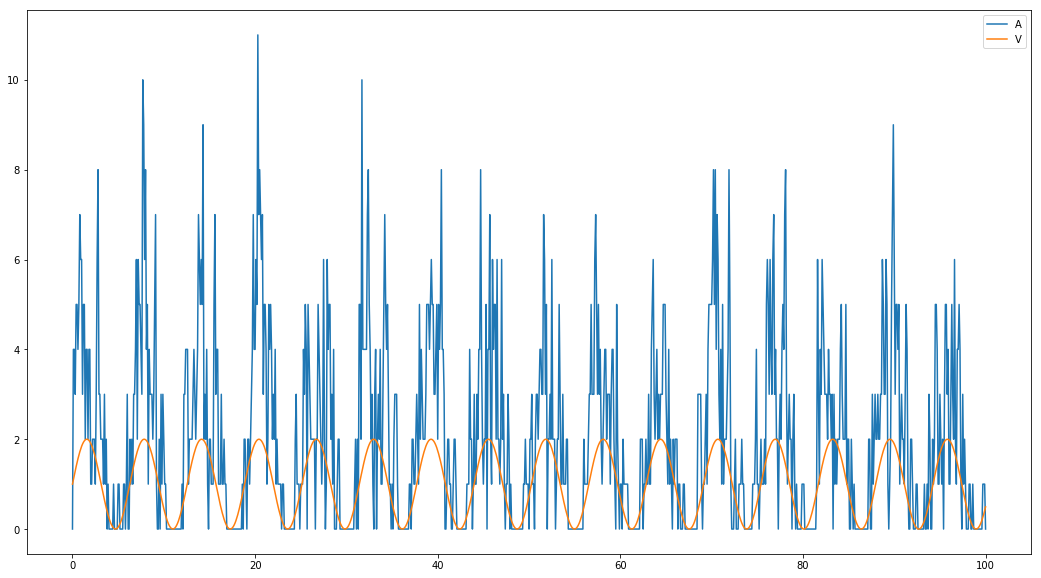

In [37]:
plt.figure(figsize=(18,10))
plt.plot(results['time'], results['A'], label='A')
plt.plot(results['time'], results['V'], label='V')
plt.legend(loc='best')


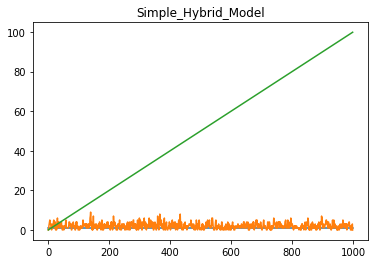

In [8]:
model.plot(results2)

In [9]:
min(results['A'])

0

In [28]:
import time
from gillespy2 import StochKitSolver, BasicSSASolver
run_data = []
timing_data = {'tau':[], 'basic':[]}
for n in range(1,51, 5):
    model = SimpleHybridModel(init_v=n)
    time_start = time.perf_counter()
    model.run(solver=BasicTauHybridSolver(), show_labels=True)
    time_end = time.perf_counter()
    run_data.append(time_end-time_start)
timing_data['tau'] = run_data
run_data = []
for n in range(1,51, 5):
    model = SimpleHybridModel(init_v=n)
    time_start = time.perf_counter()
    model.run(solver=BasicSSASolver(), show_labels=True)
    time_end = time.perf_counter()
    run_data.append(time_end-time_start)
timing_data['basic'] = run_data
print(timing_data)

{'tau': [1.301700137941225, 3.8285756464744054, 6.27767113486027, 8.574287541637318, 10.715439908078906, 12.876057226215607, 15.805673042912872, 18.341035374491526, 20.38046191766955, 22.71599414784248], 'basic': [0.14731129714721192, 0.8966033507825841, 1.6268801591977535, 2.391389273007235, 3.2344766999566446, 3.9474709557456436, 4.5709322364022, 5.358878140212028, 6.0983304113789245, 6.8481886514395]}


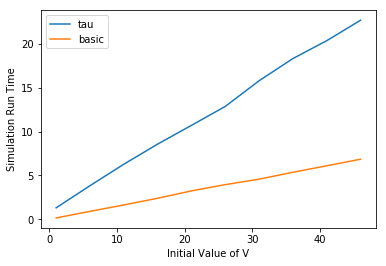

In [33]:
start_values = []
for n in range(1, 51, 5):
    start_values.append(n)
plt.plot(start_values, timing_data['tau'], label='tau')
plt.plot(start_values, timing_data['basic'], label='basic')
plt.xlabel('Initial Value of V')
plt.ylabel('Simulation Run Time')
plt.legend(loc='best')

In [39]:
import cProfile
model=SimpleHybridModel(init_v=51)
cProfile.run('model.run(solver=BasicTauHybridSolver(), show_labels=True, debug=False)', sort='tot')

         10945443 function calls in 31.855 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1796060    6.354    0.000    7.875    0.000 {built-in method builtins.eval}
        1    5.429    5.429   33.109   33.109 basic_tau_hybrid_solver.py:103(run)
    99514    4.289    0.000    9.767    0.000 _ode.py:907(run)
   532344    2.593    0.000    5.198    0.000 basic_tau_hybrid_solver.py:19(f)
    99514    1.927    0.000   21.019    0.000 basic_tau_hybrid_solver.py:63(get_reactions)
   199028    1.480    0.000    2.070    0.000 _ode.py:859(reset)
    99514    0.885    0.000   18.582    0.000 basic_tau_hybrid_solver.py:41(get_reaction_integrate)
    99514    0.773    0.000    4.103    0.000 _ode.py:371(set_integrator)
   199028    0.712    0.000    0.712    0.000 {built-in method numpy.core.multiarray.array}
    99514    0.693    0.000    7.255    0.000 _ode.py:359(set_initial_value)
    99514    0.525    0.000    0.845    0.000

TODO:
if profile = true:
Add debugging information to display step sizes and steps rejected
(append every step to an array)
plot over time and histogram
prop * tau = mean, feed to poisson random number

In [1]:
import numpy as np